# Measuring the acceleration of the cumulative case counts using calculus

This notebook is inspired by the calculus and physics courses I took in high school. Also, there is one paper that looks at something similar to this using some of the early data from China: https://ghrp.biomedcentral.com/articles/10.1186/s41256-020-00137-4

In general, when looking at real-time incident case counts, it is difficult to figure out when we have peaked, when we have left the peak and if there will be another peak. The typical approach is to model the effective reproduction number using Bayesian estimation techniques (see [Bettencourt and Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185), [Systrom 2020](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/), and [Whitehead 2020](https://www.kaggle.com/freealf/estimation-of-rt-from-cases/)), but that approach requires many assumptions about the underlying nature of the disease.

The key insight from calculus and physics is that looking at the 2nd derivative of the cumulative case counts (i.e., the acceleration) will help to indicate when the slope of the incident curve is positive (pre-peak; increases in the number of new cases per day), zero (peak; no change in the number of new cases per day) or negative (post-peak; decreases in the number of new cases per day). This is very similar indication-wise to the calculation of the effective reproduction number and its use to indicate when the pandemic starts to speed up or slow down.

The approach taken in this notebook involves 2 key steps:
1. Calculate the acceleration of the cumulative case counts using [numerical differentiation](https://en.wikipedia.org/wiki/Numerical_differentiation) 
1. Apply a simple 7-day moving average function to smooth out the data.

The main advantage of this method is that it does not require any assumptions about the underlying distribution or dynamics of the disease. It is strictly looking at the acceleration of cumulative cases over time. The main disadvantage is that it solely relies on confirmed case count data, which may be under-reported for a variety of reasons (e.g., insufficient testing).

Here we go!

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import datetime
import statsmodels.api as sm
import plotly.graph_objects as go
import plotly.express as px

In [ ]:
from datetime import datetime
def to_date(datetime_str):
    datetime_object =  np.datetime64(datetime.strptime(datetime_str, '%Y-%m-%d'))
    return datetime_object

In [ ]:
canada_cases_df = pd.read_csv('/kaggle/input/covid19-challenges/test_data_canada.csv')
canada_cases_df['date'] = canada_cases_df['date'].apply(to_date)   # Convert dates from str to datetime
days = sorted(list(set(canada_cases_df['date'].values)))

ontario_cases_df = canada_cases_df.loc[canada_cases_df['province'].isin(['Ontario'])]
ontario_counts = ontario_cases_df.groupby(['date']).nunique()['case_id']  # We count unique case_ids to avoid duplication

In [ ]:
current_day = days[0]- np.timedelta64(1,'D')

all_dates = [current_day]
while current_day != np.datetime64(to_date("2020-12-31")):
    current_day = current_day + np.timedelta64(1,'D')
    all_dates.append(current_day)

# Load up the cumulative cases

In [ ]:
incident_cases = [ontario_counts.get(date,0) if date in np.arange(datetime(2020,1,24), datetime(2020,4,26), timedelta(days=1)) else np.nan for date in all_dates]

# cumulative cases
cumulative_cases = []
for index in range(len(incident_cases)):
    if index-1 < 0:
        cumulative_cases.append(0)
    elif np.isnan(cumulative_cases[index-1]):
        cumulative_cases.append(incident_cases[index])
    else:
        cumulative_cases.append(incident_cases[index]+cumulative_cases[index-1])


# Calculate the derivatives
The numerical differentiation used here involves calculating the [centered difference](https://en.wikipedia.org/wiki/Finite_difference) in order to get the best approximation of the derivative. As a result, the acceleration calculation lags 2 days behind the current date.

In [ ]:
# First derivative
first_deriv = []
for index in range(len(incident_cases)):
    if index-1 < 0 or index +1 >= len(cumulative_cases) or np.isnan(cumulative_cases[index+1]):
        first_deriv.append(np.nan)
    else:
        value_next_date = all_dates[index+1]
        value_prev_date = all_dates[index-1]
        difference_date = np.timedelta64(value_next_date- value_prev_date,"D") / np.timedelta64(1,"D")

        value_next_cumulative = cumulative_cases[index+1]
        value_prev_cumulative = cumulative_cases[index-1]
        difference_cumulative = value_next_cumulative - value_prev_cumulative

        first_deriv.append(difference_cumulative/difference_date)
        
# Second derivative
second_deriv = []
for index in range(len(incident_cases)):
    if index-1 < 0 or index +1 >= len(cumulative_cases) or np.isnan(cumulative_cases[index+1]) or np.isnan(cumulative_cases[index-1]):
        second_deriv.append(np.nan)
    else:
        value_next_date = all_dates[index+1]
        value_prev_date = all_dates[index-1]
        difference_date = np.timedelta64(value_next_date- value_prev_date,"D") / np.timedelta64(1,"D")
        
        value_next_firstdev = first_deriv[index+1]
        value_prev_firstdev = first_deriv[index-1]
        difference_firstdev = value_next_firstdev - value_prev_firstdev
        
        second_deriv.append(difference_firstdev/difference_date)

# 7-day moving average for smoothness
A simple 7-day moving average is calculated by taking the arithmetic mean of the past 7 days of the acceleration data. An exponential moving average was considered, but because it heavily weighs the most recent data, it fluctuates more rapidly with change in the data. Using a simple 7-day moving average fluctuates more slowly, which may be more appropriate in this context when trying to ascertain if there really was a change in the acceleration or not. 

In [ ]:
# 7-day moving average
moving_average = []
std_plus = []
std_minus = []
for index in range(len(incident_cases)):
    start_index = index-5
    end_index = index+1
    
    if start_index < 0:
        moving_average.append(np.nan)
        std_plus.append(np.nan)
        std_minus.append(np.nan)
    else:
        window = second_deriv[start_index:end_index+1]
        if np.any(np.isnan(window)):
            moving_average.append(np.nan)
            std_plus.append(np.nan)
            std_minus.append(np.nan)
        else:
            mean = np.mean(window)
            stdplus = mean + np.std(window)
            stdminus = mean - np.std(window)
            
            moving_average.append(mean)
            std_plus.append(stdplus)
            std_minus.append(stdminus)

In [ ]:
final_df = pd.DataFrame({"date":all_dates, "incident_count":incident_cases, "cumulative_count":cumulative_cases, "first_derivative":first_deriv, "second_derivative":second_deriv, "moving_average":moving_average, "std_plus": std_plus, "std_minus":std_minus})
final_df.head(20)

In [ ]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(x="date", y="moving_average", data=final_df)
ax.fill_between(final_df["date"], y1=final_df["std_minus"], y2=final_df["std_plus"], alpha=.5)

Tracking the 7d-MA line would not only help indicate when we leave the first peak, it would also help indicate the likelihood of a rise in the incident cases again. After the first peak levels out, the 7d-MA line should hover around zero. Once it starts to peek above zero, that indicates that the past 7 days are pointing to a consistent net positive average acceleration, which may indicate the start of another peak. And perhaps similar to a run chart (or another [statistical process control](https://www.nature.com/articles/s41598-019-53908-6.pdf) [method](http://www.ihi.org/Topics/COVID-19/Pages/COVID-19-Data-Dashboard.aspx)), more than "x" number of positive values of the 7d-MA raises a red flag.

This type of analysis can also be applied to cumulative deaths, hospitalizations, etc. Doesn’t have to be limited to just confirmed case counts.

# Bonus content: Relationship with Rt
So, it turns out that the acceleration of cumulative case counts has a fundamental relationship with Rt.

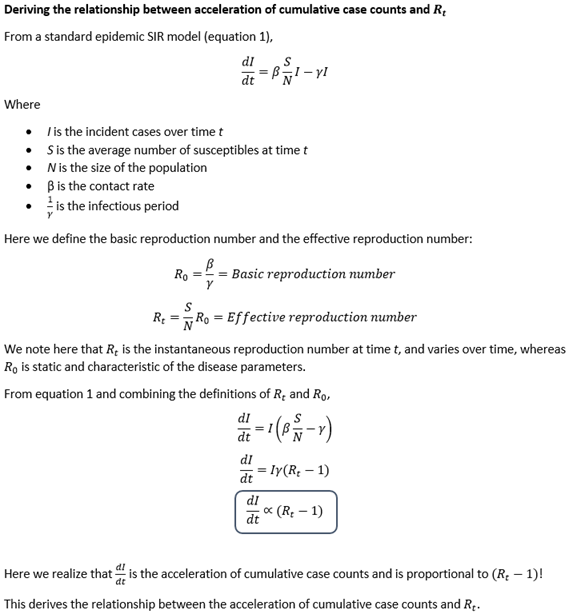